# Estimating Eddy Diffusivity, K_e

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [3]:
# Set title size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16  # Titles larger

# Set axis label size
plt.rcParams['axes.labelsize'] = 14  # Labels slightly smaller

$$K_e = K_\rho (\partial_z \theta_e)^2 / (\nabla_n \theta_m)^2$$

- Term 1: $K_rho$
- Term 2: $(\partial_z \theta_e)^2$
- Term 3: $(\nabla_n \theta_m)^2$

$$K_e = K_\rho (\partial_z \theta_e)^2 / |(\nabla_n \theta_m)|^2$$

$$\widetilde{u}\widetilde{S} = \kappa(\frac{\Delta\widetilde{S}}{\Delta z})^2 / (\frac{\Delta\overline{S}}{\Delta x})$$

$\kappa = 10^{-4} \frac{m^2}{s}$

$(\frac{\Delta\widetilde{T}}{\Delta z}) = 0.025 \frac{^\circ C}{m}$, $(\frac{\Delta\widetilde{T}}{\Delta z})^2 = 6.25 x 10^{-4} \frac{^\circ C}{m}$

$(\frac{\Delta\overline{T}}{\Delta x}) = 10^{-4} \frac{^\circ C}{m}$

$\widetilde{u}\widetilde{T} = 6.25 x 10^{-4} \frac{^\circ C m}{s}$

# Functions

In [4]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [5]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[['PRES_INTERPOLATED'], ['PRES_INTERPOLATED']],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    #ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

In [33]:
def get_ds_gridded(ds, lon_bins, lat_bins):
    # Step 1: Reduce using flox
    ds_binned = xarray_reduce(
        ds,
        'LONGITUDE',
        'LATITUDE',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins)
        ),
        fill_value=np.nan,
        skipna=True
    )

    # Step 2: Rename dimensions and variables
    ds_binned = ds_binned.rename_dims({
        'LONGITUDE_bins': 'lon',
        'LATITUDE_bins': 'lat',
        'rho_grid': 'density'
    }).rename_vars({
        'LONGITUDE_bins': 'lon',
        'LATITUDE_bins': 'lat',
        'rho_grid': 'density'
    })

    # Step 3: Replace Interval coordinates with midpoints
    def interval_midpoints(intervals):
        return np.array([interval.mid for interval in intervals])

    ds_binned = ds_binned.assign_coords({
        'lon': ('lon', interval_midpoints(ds_binned['lon'].values)),
        'lat': ('lat', interval_midpoints(ds_binned['lat'].values))
    })

    # Step 4: Generate grid and xgcm object
    ds_gridded = generate_grid_ds(ds_binned, {'X': 'lon', 'Y': 'lat'})
    grid = Grid(ds_gridded, coords={
        'X': {'center': 'lon', 'left': 'lon_left'},
        'Y': {'center': 'lat', 'left': 'lat_left'},
        'Z': {'center': 'density'}
    }, periodic=['X'])

    return ds_gridded, grid

In [58]:
def get_grad(ds_gridded, grid, var):
    dlong = grid.diff(ds_gridded.lon, 'X')
    dlatg = grid.diff(ds_gridded.lat, 'Y', boundary='fill', fill_value=np.nan)
    
    distance_1deg_equator = 111000
    dx = dlong * np.cos(np.deg2rad(ds_gridded.lat)) * distance_1deg_equator
    dy = ((ds_gridded.lon * 0) + 1) * dlatg * distance_1deg_equator
    
    dC_dx = grid.diff(ds_gridded[var], 'X') / dx
    dC_dy = grid.diff(ds_gridded[var], 'Y') / dy
    
    dC_dx = grid.interp(dC_dx, ['X'], to='center')
    dC_dy = grid.interp(dC_dy, ['Y'], to='center')
    
    return dC_dx, dC_dy

## Term (1)

In [24]:
diff_rho = xr.open_dataset('/swot/SUM05/amf2288/diff_rho_3.nc')
K_rho = diff_rho.K_rho

In [25]:
K_rho = K_rho.rename({'rho_grid':'density'})

## Term (2)

In [26]:
lfilt = 100
rho_grid = np.arange(21,29,0.0025)
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-67.5,68,3)

In [27]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [28]:
ct_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_e_3.nc', chunks={'N_PROF':100000})

In [29]:
ct_e_z2 = ct_e.differentiate(coord='PRES_INTERPOLATED')**2

In [30]:
%%time
ct_e_z2_filt = ff.da_filt_single(ct_e_z2, lfilt)

CPU times: user 1min 56s, sys: 1min 31s, total: 3min 28s
Wall time: 2min 39s


In [31]:
ct_e_z2_filt.name = 'ct_e_z2_filt'
ct_e_z2_filt = ct_e_z2_filt.to_dataset()

In [35]:
%%time
ct_e_z2_filt_rho = get_ds_rho(ct_e_z2_filt, ds.SIG0, rho_grid, variables=['ct_e_z2_filt'])

Completed comp for ct_e_z2_filt
Completed ct_e_z2_filt
Completed merge
CPU times: user 8min 16s, sys: 43.6 s, total: 9min
Wall time: 9min


In [36]:
%%time
term2, term2_grid = get_ds_gridded(ct_e_z2_filt_rho, lon_bins, lat_bins)

CPU times: user 3min 31s, sys: 39.7 s, total: 4min 10s
Wall time: 4min 10s


In [37]:
term2

<xarray.Dataset> Size: 138MB
Dimensions:       (density: 3200, lon: 120, lat: 45, lon_left: 120, lat_left: 45)
Coordinates:
  * density       (density) float64 26kB 21.0 21.0 21.01 ... 28.99 29.0 29.0
  * lon           (lon) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * lat           (lat) float64 360B -66.0 -63.0 -60.0 -57.0 ... 60.0 63.0 66.0
  * lon_left      (lon_left) float64 960B -180.0 -177.0 -174.0 ... 174.0 177.0
  * lat_left      (lat_left) float64 360B -67.5 -64.5 -61.5 ... 58.5 61.5 64.5
Data variables:
    ct_e_z2_filt  (density, lon, lat) float64 138MB dask.array<chunksize=(3200, 120, 45), meta=np.ndarray>

In [38]:
term2_grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_left --> center
Y Axis (not periodic, boundary=None):
  * center   lat --> left
  * left     lat_left --> center
Z Axis (not periodic, boundary=None):
  * center   density

In [39]:
%%time
term2.to_netcdf('/swot/SUM05/amf2288/var-boxes/term2.nc')

CPU times: user 2min 1s, sys: 4min 54s, total: 6min 55s
Wall time: 1min 5s


## Term (3)

In [40]:
ct_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_3.nc', chunks={'N_PROF':100000})

In [41]:
ct_m.name = 'ct_m'
ct_m = ct_m.to_dataset()

In [42]:
%%time
ct_m_rho = get_ds_rho(ct_m, ds.SIG0, rho_grid, variables=['ct_m'])

Completed comp for ct_m
Completed ct_m
Completed merge
CPU times: user 18.8 s, sys: 9.1 s, total: 27.9 s
Wall time: 27.9 s


In [43]:
%%time
ct_m_rho_gridded, ct_m_rho_grid = get_ds_gridded(ct_m_rho, lon_bins, lat_bins)

CPU times: user 31.5 ms, sys: 863 μs, total: 32.4 ms
Wall time: 30.9 ms


In [44]:
ct_m_rho_gridded

<xarray.Dataset> Size: 138MB
Dimensions:   (density: 3200, lon: 120, lat: 45, lon_left: 120, lat_left: 45)
Coordinates:
  * density   (density) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0
  * lon       (lon) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * lat       (lat) float64 360B -66.0 -63.0 -60.0 -57.0 ... 57.0 60.0 63.0 66.0
  * lon_left  (lon_left) float64 960B -180.0 -177.0 -174.0 ... 171.0 174.0 177.0
  * lat_left  (lat_left) float64 360B -67.5 -64.5 -61.5 -58.5 ... 58.5 61.5 64.5
Data variables:
    ct_m      (density, lon, lat) float64 138MB dask.array<chunksize=(3200, 120, 45), meta=np.ndarray>

In [45]:
ct_m_rho_grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_left --> center
Y Axis (not periodic, boundary=None):
  * center   lat --> left
  * left     lat_left --> center
Z Axis (not periodic, boundary=None):
  * center   density

In [59]:
ct_m_dx, ct_m_dy = get_grad(ct_m_rho_gridded, ct_m_rho_grid, 'ct_m')

/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will b

In [61]:
term3 = ct_m_dx**2 + ct_m_dy**2

In [ ]:
%%time
ct_m_dx.to_netcdf('/swot/SUM05/amf2288/var-boxes/ct_m_dx.nc')

In [ ]:
%%time
ct_m_dy.to_netcdf('/swot/SUM05/amf2288/var-boxes/ct_m_dy.nc')

In [ ]:
%%time
term3.to_netcdf('/swot/SUM05/amf2288/var-boxes/Ke_term3.nc')

# Plots

In [30]:
%%time
term2_ds = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/term2.nc').load()
term2 = term2_ds.ct_e_z2_filt.rename('term2')
term3 = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/Ke_term3.nc').rename('term3').load()
ct_m_dx = xr.open_dataa

CPU times: user 0 ns, sys: 502 ms, total: 502 ms
Wall time: 499 ms


In [31]:
K_e = K_rho*term2/term3**2

In [32]:
%%time
K_e.to_netcdf('/swot/SUM05/amf2288/var-boxes/K_e.nc')

CPU times: user 9.96 ms, sys: 85.7 ms, total: 95.6 ms
Wall time: 96.2 ms


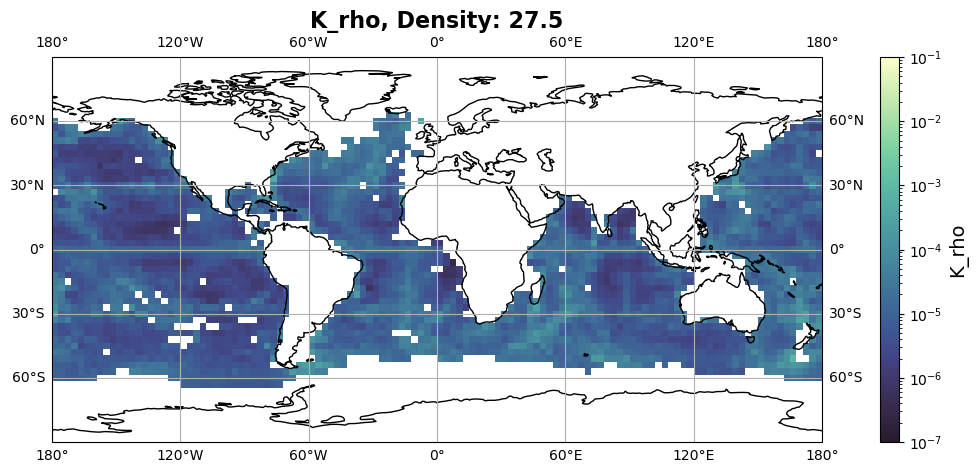

In [72]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
K_rho.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-7, vmax=1e-1))
ax.set_title('K_rho, Density: {}'.format(np.round(term2.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/K_rho_275.png', bbox_inches='tight')

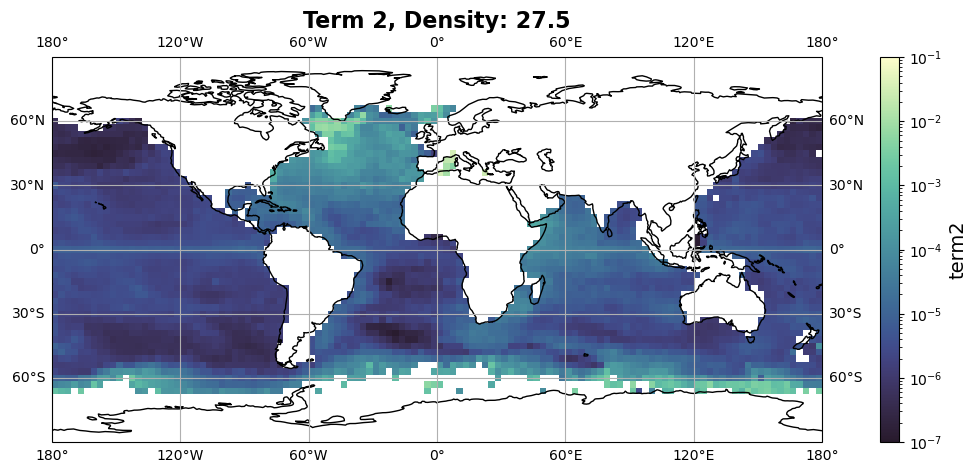

In [71]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
term2.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-7, vmax=1e-1))
ax.set_title('Term 2, Density: {}'.format(np.round(term2.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/term2_275.png', bbox_inches='tight')

Text(0.5, 1.0, 'Term 3, Density: 27.5')

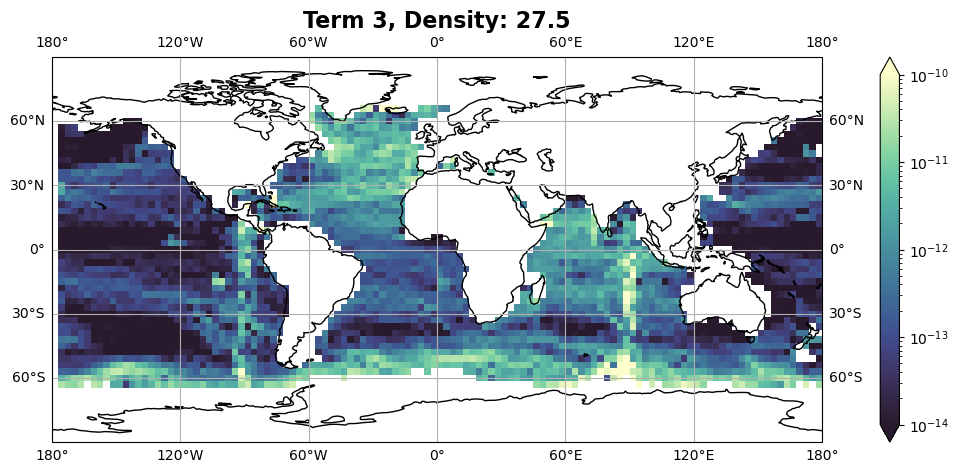

In [95]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
term3.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-14, vmax=1e-10))
ax.set_title('Term 3, Density: {}'.format(np.round(term3.sel(density=density, method='nearest').density.values, 1)))
#plt.savefig('../notebooks/argo_clim/figs/term3_275.png', bbox_inches='tight')

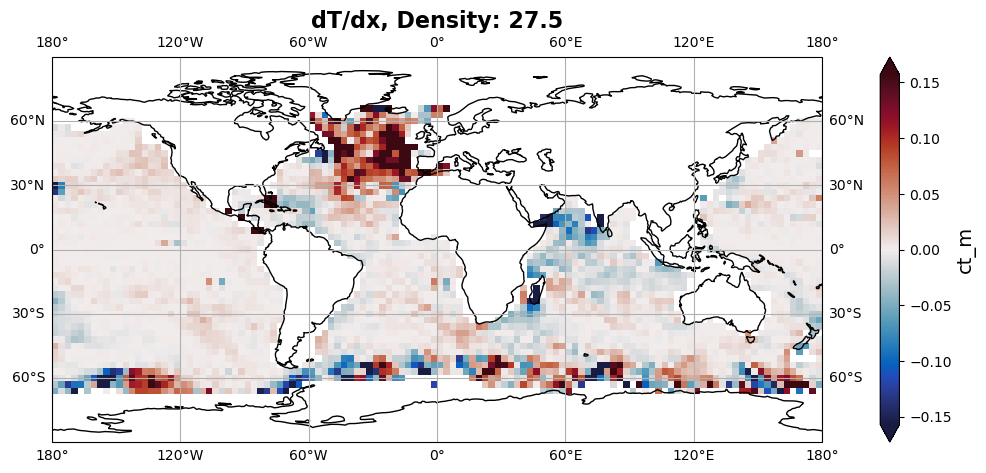

In [74]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ct_m_rho_binned_dx.ct_m.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.balance, robust=True)
ax.set_title('dT/dx, Density: {}'.format(np.round(term3.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/dTdx_275.png', bbox_inches='tight')

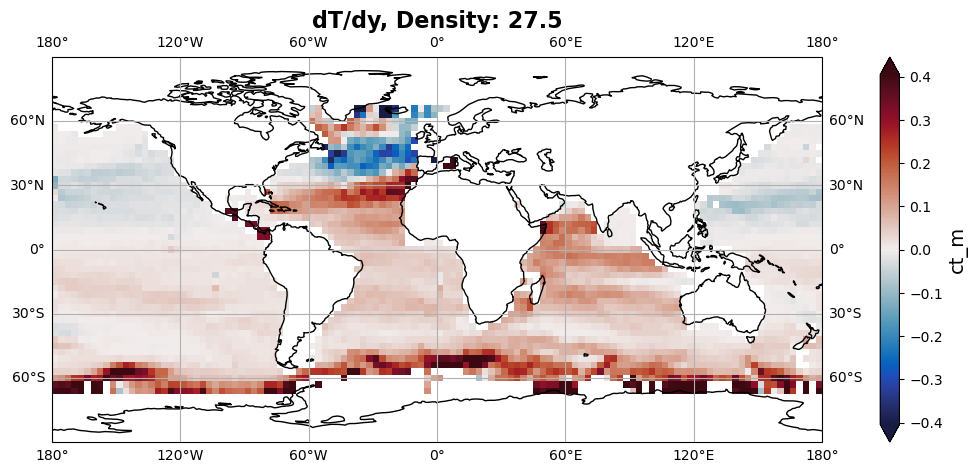

In [73]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ct_m_rho_binned_dy.ct_m.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.balance, robust=True)
ax.set_title('dT/dy, Density: {}'.format(np.round(term3.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/dTdy_275.png', bbox_inches='tight')

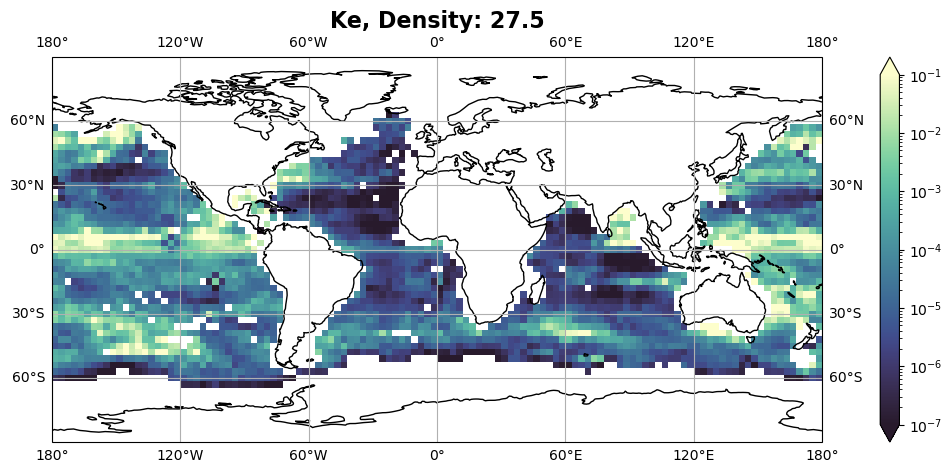

In [69]:
density = 27.5

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
K_e.sel(density=density, method='nearest').plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.deep_r, norm=colors.LogNorm(vmin=1e-7, vmax=1e-1))
ax.set_title('Ke, Density: {}'.format(np.round(K_e.sel(density=density, method='nearest').density.values, 1)))
plt.savefig('../notebooks/argo_clim/figs/K_e_275.png', bbox_inches='tight')